In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pandas as pd
import random
import graphviz
import seaborn as sns
import time
import math
from torch.nn.utils import clip_grad_norm_

from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

BATCH_SIZE = 32
EXAMPLE_SIZE = 10

Mounted at /content/drive


In [2]:
path_1 = "/content/drive/MyDrive/Monarch/RL/Tic Tac Toe/Transformers/offline training data/nn_training_data_first_half.csv"
path_2 = "/content/drive/MyDrive/Monarch/RL/Tic Tac Toe/Transformers/offline training data/nn_training_data_second_half.csv"
path_3 = "/content/drive/MyDrive/Monarch/RL/Tic Tac Toe/Transformers/offline training data/nn_training_data_third_half.csv"

offline_TTT_trajectories_first_half = pd.read_csv(path_1).to_numpy()
offline_TTT_trajectories_second_half = pd.read_csv(path_2).to_numpy()
offline_TTT_trajectories_third_half = pd.read_csv(path_3).to_numpy()

offline_TTT_trajectories = np.concatenate((offline_TTT_trajectories_first_half, offline_TTT_trajectories_second_half, offline_TTT_trajectories_third_half), axis=0)
#1758071 games
print(offline_TTT_trajectories.shape)

# Epoch is one pass through the entire training data
epochs = []

# batch is n examples together

# example is one trajectory

counter = 0
empty_board = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
examples = []
example = []
for trajectory in offline_TTT_trajectories:
  if example and np.array_equal(trajectory[1:10], empty_board):
    # if counter == 258073:
      # print("incorrect trajectory")
      # break
    while len(example) < EXAMPLE_SIZE:
      example.append(empty_board)
    examples.append(example)
    counter += 1

    example = []
  example.append(trajectory[1:10])

def generate_batch(batch_number):
  batch = examples[batch_number * BATCH_SIZE: (batch_number + 1) * BATCH_SIZE]
  return batch

(15167926, 10)


In [3]:
# 1. Define your environment
class TicTacToe:
  def __init__(self):
    self.board = np.zeros((3, 3))
    self.one_move_back = np.zeros((3, 3))
    self.two_moves_back = np.zeros((3, 3))

  def reset(self, batch_number, entry_in_batch):
    self.board_list = generate_batch(batch_number)[entry_in_batch]
    self.board = self.board_list[0].copy().reshape(3, 3)
    self.one_move_back = np.zeros((3, 3))
    self.two_moves_back = np.zeros((3, 3))
    return [self.two_moves_back, self.one_move_back, self.board]

  def check_win(self, player):
    # Check rows
    for i in range(3):
      if np.all(self.board[i, :] == player):
        return player

    # Check columns
    for j in range(3):
      if np.all(self.board[:, j] == player):
        return player

    #Check diagonal
    if np.all(np.diag(self.board) == player):
      return player
    if np.all(np.diag(np.fliplr(self.board)) == player):
      return player

    #Check tie
    if np.all(self.board != 0):
      return -1

    return 0

  # Check for empty places on board
  def possibilities(self):
    l = []
    for i in range(len(self.board)):
      for j in range(len(self.board)):
        if self.board[i][j] == 0:
          l.append((i, j))
    return(l)

  # Next Move
  def next_move(self, move_number):
    print("move number: ", move_number)
    next_board = self.board_list[move_number].copy().reshape(3,3)
    board_index = 0
    for i in range(3):
      for j in range(3):
        if next_board[i][j] != self.board[i][j]:
          return board_index
        board_index += 1

  def network_step(self, action, player):
    #print(action)
    self.two_moves_back = self.one_move_back.copy()
    self.one_move_back = self.board.copy()
    row, col = action
    self.board[row, col] = player
    done = self.check_win(player)
    reward = 0
    if done == 1:
      reward = 1
    if done == 2:
      reward = -1.5
    state = np.concatenate((self.two_moves_back, self.one_move_back, self.board), axis=0)
    return state, reward, done

  def network_best_move(self):
    self.two_moves_back = self.one_move_back.copy()
    self.one_move_back = self.board.copy()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Get the device
    policy.to(device)

    action_mask = np.zeros((3, 3))
    for i in range(len(action_mask)):
      for j in range(len(action_mask)):
        if self.board[(i,j)] == 0:
          action_mask[i][j] = 1
    action_mask = torch.FloatTensor(action_mask.flatten()).to(device)

    state = np.concatenate((self.two_moves_back, self.one_move_back, self.board), axis=0)
    state = torch.FloatTensor(state.flatten()).unsqueeze(0).to(device)
    probs = policy(state)


    action_probabilities = Categorical(probs * action_mask)
    action = torch.argmax(action_probabilities.probs, dim=0)

    self.board[tensor_to_tuple[action.item()]] = 1
    done = self.check_win(1)

    return self.board, done

#takes a 2-d numpy array and create a string representation
def numpy_array_to_string(array):
  string_array = ""
  for row in array:
    for element in row:
      string_array += str(element)
  return string_array

In [4]:
class TransformerAgent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, nhead, num_layers, dropout=0.10):
        super(TransformerAgent, self).__init__()
        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=nhead,
                                          num_decoder_layers=num_layers,
                                          num_encoder_layers=num_layers,
                                          dropout=dropout)
        # Instead of an Embedding layer, use a Linear layer to handle continuous state values
        self.state_embedding = nn.Linear(state_dim, hidden_dim)
        self.actor = nn.Linear(hidden_dim, action_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.state_dim = state_dim

    def forward(self, x):
        # Embed the input using the Linear layer
        x = self.state_embedding(x.float())
        # Reshape to (sequence_length, batch_size, embedding_dim)
        x = x.view(1, 1, -1) # Reshape for Transformer

        # Pass through the Transformer
        output = self.transformer(x, x)[0, -1, :]
        # output (logits)
        logits = self.actor(output)
        #Softmax to get probs
        probs = self.softmax(logits)
        return probs

In [5]:
tensor_to_tuple = {}
for i in range(9):
  tensor_to_tuple[i] = (i//3, i%3)
print(tensor_to_tuple)

{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2), 6: (2, 0), 7: (2, 1), 8: (2, 2)}


In [6]:
from logging import log
#Tic Tac Toe version
def compute_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    discounted_reward = 0
    i = 0
    for reward in reversed(rewards):
        discounted_reward = reward + gamma * discounted_reward
        discounted_rewards.insert(0, discounted_reward)
        # print(i," discounted_rewards: ", discounted_rewards)
        i += 1
    discounted_rewards = torch.tensor(discounted_rewards)


    #discounted_rewards = discounted_reward - discounted_rewards.mean() / (discounted_rewards.std() + 1e-5)
    # print("discounted rewards: ", discounted_rewards)

    return discounted_rewards

# Training loop
def train(env, policy, optimizer, n_episodes, batch_size):
  total_reward = 0
  games_won = 0
  games_lost = 0
  games_skipped = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")
  # Move model and optimizer to GPU
  policy.to(device)
  for episode in range(n_episodes):
    player_one_states = []
    actions = []
    rewards = []
    invalid_state = False
    for i in range(batch_size):

      print("episode: ", episode)
      print("trajectory: ", i)
      if (len(actions) != len(player_one_states)):
        print("actions and p1 states aren't being updated properly!!")
        break

      done = 0
      state = [entry.flatten() for entry in env.reset(episode, i)]
      state = np.concatenate((state[0], state[1], state[2]), axis=None)
      #player_one_states.append(torch.tensor(state, dtype=torch.float32))
      move_number = 1
      print(state.flatten()[18:27].reshape(3,3))

      while done == 0:
        player_one_states.append(torch.tensor(state, dtype=torch.float32))

        # 1. Choose action (using the model - softmax for probabilities)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        # action_probs = TransformerAgent.softmax(policy(state_tensor), dim=-1)
        action = env.next_move(move_number)
        actions.append(action)
        action_tuple = tensor_to_tuple[action]

        valid_moves = env.possibilities()
        if action_tuple not in valid_moves:
          print("invalid move")
          invalid_state = True
          games_skipped += 1
          player_one_states = player_one_states[:-int(move_number/2)]
          actions = action[:-int(move_number/2)]
          rewards = rewards[:-int(move_number/2)]
          break

        # 2. Interact with the environment
        next_state, reward, done = env.network_step(action_tuple, player = 1)

        print(next_state.flatten()[18:27].reshape(3,3))
        move_number += 1

        if done == 0:
          action = env.next_move(move_number)
          action_tuple = tensor_to_tuple[action]

          valid_moves = env.possibilities()
          if action_tuple not in valid_moves:
            print("invalid move")
            invalid_state = True
            games_skipped += 1
            player_one_states = player_one_states[:-int(move_number/2)]
            print(actions)
            actions = actions[:-int(move_number/2)]
            print(actions)
            rewards = rewards[:-int(move_number/2)]
            break

          next_state, reward, done = env.network_step(action_tuple, player = 2)
          print(next_state.flatten()[18:27].reshape(3,3))
          move_number += 1
        rewards.append(reward)
        state = next_state

      #print(state.flatten()[18:27].reshape(3,3))
      print("DONE!!! ", done)
      if sum(rewards) == 1:
        games_won += 1
      elif sum(rewards) == -1:
        games_lost += 1
      episode_rewards.append(sum(rewards))
      discounted_rewards = compute_discounted_rewards(rewards)

    # 4. Update the model (REINFORCE)
    optimizer.zero_grad()
    policy_loss = 0
    print("player one states: ", len(player_one_states))
    print("actions: ", len(actions))
    for t in range(len(player_one_states)-1):
        state_tensor = player_one_states[t].unsqueeze(0).to(device) # Add batch dimension
        action_probs = policy(state_tensor.flatten())
        #print("state: \n", player_one_states[t].flatten()[18:27].reshape(3,3))
        #print("action[t]: ", actions[t])
        log_prob = torch.log(action_probs[actions[t]])  # Get log prob of the chosen action
        discounted_reward_t = discounted_rewards[t].to(device)
        policy_loss -= discounted_rewards[t] * log_prob  # REINFORCE loss
    policy_loss.backward()
    optimizer.step()
    episode_losses.append(policy_loss.item())
    if episode % 1600 == 0:
      print("saved model: ", episode)
      # Save the trained policy network
      torch.save(policy.state_dict(), '/content/drive/MyDrive/Monarch/RL/Tic Tac Toe/Transformers/offline policy networks 512/transformer_network_' + str(episode/800)+'.pth')





In [ ]:
#Globals
episode_rewards = []
episode_losses = []
games_skipped = 0

time_start = time.time()

#Driver code for training the model
my_env = TicTacToe()
print("")
policy = TransformerAgent(state_dim=27, action_dim=9, hidden_dim=512, nhead=8, num_layers=6)
#print("Policy: ", policy)
policy.train()
total_params = sum(p.numel() for p in policy.parameters())
print(f"Number of parameters: {total_params}")
#Learning rate used to be 1e-6
optimizer = optim.Adam(policy.parameters(), lr=1e-6)

#train(env, policy, optimizer)
train(my_env, policy, optimizer, n_episodes=96001, batch_size=BATCH_SIZE)

time_end = time.time()
time_elapsed = time_end - time_start
print("Time elapsed: ", time_elapsed)
print("games won: ", sum(episode_rewards))
print("games lost: ", 16000*32-sum(episode_rewards))
print("games skipped: ", games_skipped)



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Streaming output truncated to the last 5000 lines.
 [1 0 2]]
move number:  5
[[0 0 2]
 [1 0 1]
 [1 0 2]]
move number:  6
[[2 0 2]
 [1 0 1]
 [1 0 2]]
move number:  7
[[2 0 2]
 [1 0 1]
 [1 1 2]]
move number:  8
[[2 0 2]
 [1 2 1]
 [1 1 2]]
DONE!!!  2
episode:  14717
trajectory:  22
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
move number:  1
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
move number:  2
[[2 0 0]
 [0 0 1]
 [0 0 0]]
move number:  3
[[2 0 0]
 [0 0 1]
 [0 1 0]]
move number:  4
[[2 0 0]
 [0 0 1]
 [2 1 0]]
move number:  5
[[2 0 0]
 [0 1 1]
 [2 1 0]]
move number:  6
[[2 0 2]
 [0 1 1]
 [2 1 0]]
move number:  7
[[2 0 2]
 [0 1 1]
 [2 1 1]]
move number:  8
[[2 0 2]
 [2 1 1]
 [2 1 1]]
DONE!!!  2
episode:  14717
trajectory:  23
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
move number:  1
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
move number:  2
[[1 2 0]
 [0 0 0]
 [0 0 0]]
move number:  3
[[1 2 1]
 [0 0 0]
 [0 0 0]]
move number:  4
[[1 2 1]
 [0 2 0]
 [0 0 0]]
move number:  5
[[1 2 1]
 [0 2 0]
 [0 0 1]]
move number: 

episode_losses:  [460.9729309082031]


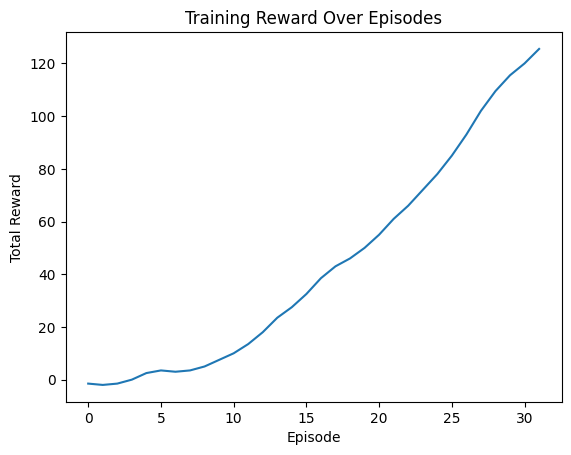

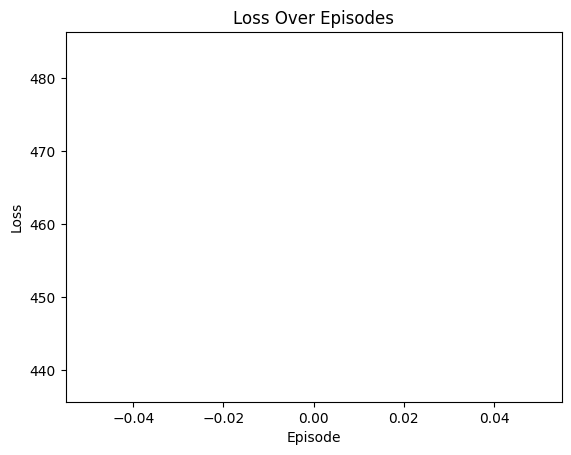

In [ ]:
cumulative_episode_rewards = []
for i in range(len(episode_rewards)):
  if i == 0:
    cumulative_episode_rewards.append(episode_rewards[i])
  else:
    cumulative_episode_rewards.append(cumulative_episode_rewards[i-1] + episode_rewards[i])
print("episode_losses: ", episode_losses)

plt.plot(cumulative_episode_rewards)
plt.title('Training Reward Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


plt.plot(episode_losses)
plt.title('Loss Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()